## Visión por Computador

**Grupo 17**:

- Sara Expósito Suárez
- Alejandro Padrón Ossorio

Paquetes necesarios

In [3]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



En la imagen hay 8 monedas que suman un total de 3.88€


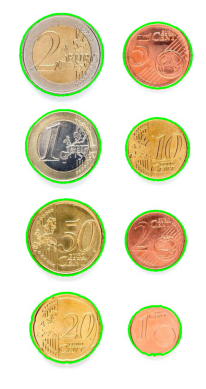

In [5]:
img = cv2.imread('Monedas2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
img_gris = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

img_ggris = cv2.GaussianBlur(img_gris, (7, 7), 0)

th,img_th = cv2.threshold(img_ggris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornos, hierarchy = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_rgb, contornos, -1, (0, 255, 0), 3)

selected_radius = None

def select_coin(event, x, y, flags, param):
    global selected_radius
    if event == cv2.EVENT_LBUTTONDOWN:
        for c in contornos:
            (cx, cy), radio = cv2.minEnclosingCircle(c)
            if cv2.pointPolygonTest(c, (x, y), False) >= 0:
                selected_radius = radio
                break

cv2.imshow("Selecciona la moneda de 1 euro", img)
cv2.setMouseCallback("Selecciona la moneda de 1 euro", select_coin)

while selected_radius is None:
    if cv2.waitKey(10) == 27:
        break

coins_diameter = [16.26, 18.75, 21.25, 19.75, 22.25, 24.25, 23.25, 25.75]
coins_value = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
coins_color = ["copper", "copper", "copper", "gold", "gold", "gold", "silver_gold", "silver_gold"]

if selected_radius:
    ratio = selected_radius * 2 / coins_diameter[6]

money_amount = 0
tolerance = 3

def get_avg_color(contornos, img_hsv):
    mask = np.zeros(img_hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, contornos, -1, 255, -1)
    mean_value = cv2.mean(img_hsv, mask=mask)
    return mean_value[:3]

def classify_color_hsv(avg_color):
    h, s, v = avg_color
    
    if 10 < h < 20 and s > 100:
        return "copper"
    elif 20 < h < 30 and s > 100:
        return "gold"
    
    return "silver_gold"

coins_count = 0

for c in contornos:
    area = cv2.contourArea(c)
    if area > 10:
        (cx, cy), radio = cv2.minEnclosingCircle(c)
        coins_count += 1
    else:
        continue

    diameter = radio * 2
    detected = False
    
    avg_color = get_avg_color(c, img_hsv)
    color = classify_color_hsv(avg_color)
    
    for coin_diameter, coin_value, coin_color in zip(coins_diameter, coins_value, coins_color):
        if abs(diameter - ratio * coin_diameter) < tolerance:
            money_amount += coin_value
            detected = True
            break

    if not detected:
        money_amount += coins_value[-1]

print(f"En la imagen hay {coins_count} monedas que suman un total de {money_amount}€")
plt.imshow(img_rgb)
plt.axis("off")

cv2.destroyAllWindows()

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

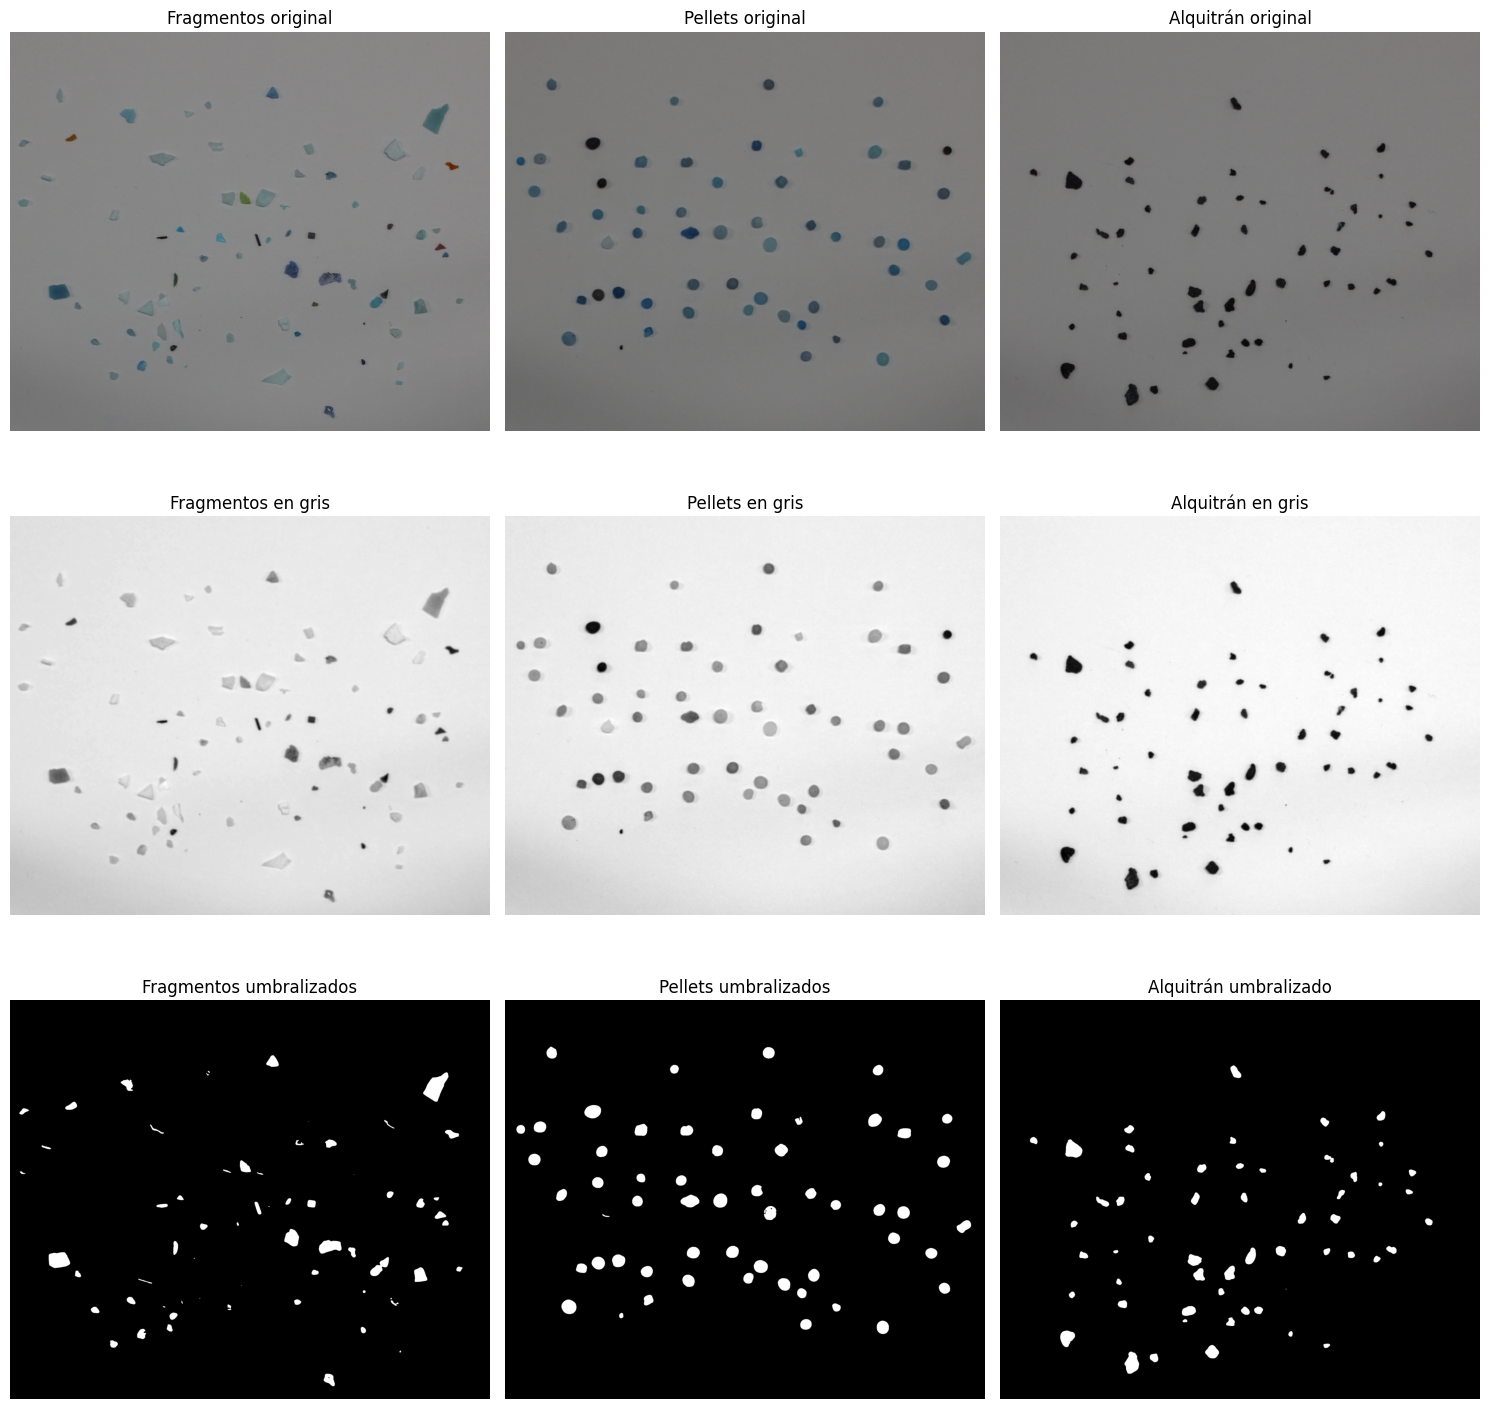

In [150]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carga imagen
fra = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pel = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
tar = cv2.imread('tar-03-olympus-10-01-2020.JPG')

# Se recortan bordes por las sombras
fra = fra[0:2700, 750:4000]
pel = pel[0:2700, 750:4000]
tar = tar[0:2700, 750:4000]

# Escala de grises
fra_gris = cv2.cvtColor(fra, cv2.COLOR_BGR2GRAY)
pel_gris = cv2.cvtColor(pel, cv2.COLOR_BGR2GRAY)
tar_gris = cv2.cvtColor(tar, cv2.COLOR_BGR2GRAY)

# Suavizado Gaussiano para reducir ruido
fra_gris = cv2.GaussianBlur(fra_gris, (25, 25), 0)
pel_gris = cv2.GaussianBlur(pel_gris, (15, 15), 0)
tar_gris = cv2.GaussianBlur(tar_gris, (15, 15), 0)

# Umbralizados
_,fra_umbral = cv2.threshold(fra_gris,110,255,cv2.THRESH_BINARY_INV)
_,pel_umbral = cv2.threshold(pel_gris,100,255,cv2.THRESH_BINARY_INV)
_,tar_umbral = cv2.threshold(tar_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Mostrar imágenes
plt.figure(figsize=(15, 15))

# Primera fila: Imágenes originales
plt.subplot(3, 3, 1)
plt.axis("off")
plt.imshow(fra, cmap='gray')
plt.title('Fragmentos original')

plt.subplot(3, 3, 2)
plt.axis("off")
plt.imshow(pel, cmap='gray')
plt.title('Pellets original')

plt.subplot(3, 3, 3)
plt.axis("off")
plt.imshow(tar, cmap='gray')
plt.title('Alquitrán original')

# Segunda fila: Imágenes en escala de grises
plt.subplot(3, 3, 4)
plt.axis("off")
plt.imshow(fra_gris, cmap='gray')
plt.title('Fragmentos en gris')

plt.subplot(3, 3, 5)
plt.axis("off")
plt.imshow(pel_gris, cmap='gray')
plt.title('Pellets en gris')

plt.subplot(3, 3, 6)
plt.axis("off")
plt.imshow(tar_gris, cmap='gray')
plt.title('Alquitrán en gris')

# Tercera fila: Imágenes umbralizadas
plt.subplot(3, 3, 7)
plt.axis("off")
plt.imshow(fra_umbral, cmap='gray')
plt.title('Fragmentos umbralizados')

plt.subplot(3, 3, 8)
plt.axis("off")
plt.imshow(pel_umbral, cmap='gray')
plt.title('Pellets umbralizados')

plt.subplot(3, 3, 9)
plt.axis("off")
plt.imshow(tar_umbral, cmap='gray')
plt.title('Alquitrán umbralizado')

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()


En la foto de Fragmentos se detectaron: Fragmentos: 57, Pellets: 6, Alquitran: 0
En la foto de Pellets se detectaron: Fragmentos: 14, Pellets: 37, Alquitran: 4
En la foto de Alquitrán se detectaron: Fragmentos: 0, Pellets: 1, Alquitran: 54


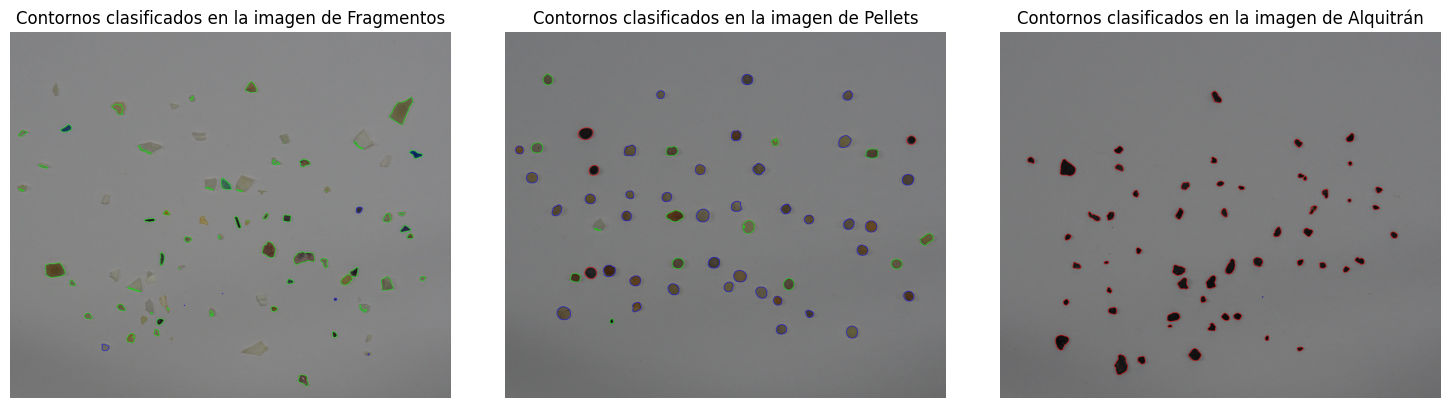

In [151]:
def clasificar_contornos(imagen_original, imagen_gris, imagen_umbralizada):
    
    # Crear una copia de la imagen original para dibujar los contornos sobre ella
    imagen_con_contornos = imagen_original.copy()

    # Encontrar los contornos en la imagen umbralizada
    contornos, _ = cv2.findContours(imagen_umbralizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Inicializar contadores
    fragmentos, pellets, alquitran = 0, 0, 0


    for contorno in contornos:
        
        # Calcular el área y el perímetro del contorno
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        _, _, w, h = cv2.boundingRect(contorno)

        # Calcular relación de aspecto y compacidad
        relacion_aspecto = w / h
        compacidad = (perimetro ** 2) / area if area > 0 else 0

        mask = np.zeros(imagen_gris.shape, dtype=np.uint8)                # Máscara en negro
        cv2.drawContours(mask, [contorno], -1, 255, thickness=cv2.FILLED) # Controno relleno de blanco
        intensidad_promedio = cv2.mean(imagen_gris, mask=mask)[0]         # Valor de intensidad promedio en la zona del contorno

        # Clasificación
        if intensidad_promedio < 50:                                                # Umbral oscuro
            alquitran += 1
            cv2.drawContours(imagen_con_contornos, [contorno], -1, (0, 0, 255), 2)  # Contorno rojo
        elif compacidad < 15.9 and np.isclose(relacion_aspecto, 1.0, rtol=0.1):     # Objetos redondos
            pellets += 1
            cv2.drawContours(imagen_con_contornos, [contorno], -1, (255, 0, 0), 2)  # Contorno azul
        else:                                                                       # Ni oscuro, ni redondo
            fragmentos += 1
            cv2.drawContours(imagen_con_contornos, [contorno], -1, (0, 255, 0), 2)  # Contorno verde

    return imagen_con_contornos, fragmentos, pellets, alquitran


imagen_fra_con_contornos, fragmentos_fra, pellets_fra, alquitran_fra = clasificar_contornos(fra.copy(), fra_gris, fra_umbral)
imagen_pel_con_contornos, fragmentos_pel, pellets_pel, alquitran_pel = clasificar_contornos(pel.copy(), pel_gris, pel_umbral)
imagen_tar_con_contornos, fragmentos_tar, pellets_tar, alquitran_tar = clasificar_contornos(tar.copy(), tar_gris, tar_umbral)

# Imprimir la cantidad de cada tipo para cada imagen
print(f"En la foto de Fragmentos se detectaron: Fragmentos: {fragmentos_fra}, Pellets: {pellets_fra}, Alquitran: {alquitran_fra}")
print(f"En la foto de Pellets se detectaron: Fragmentos: {fragmentos_pel}, Pellets: {pellets_pel}, Alquitran: {alquitran_pel}")
print(f"En la foto de Alquitrán se detectaron: Fragmentos: {fragmentos_tar}, Pellets: {pellets_tar}, Alquitran: {alquitran_tar}")

# Mostrar imágenes
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.axis("off")
plt.imshow(cv2.cvtColor(imagen_fra_con_contornos, cv2.COLOR_BGR2RGB))
plt.title('Contornos clasificados en la imagen de Fragmentos')

plt.subplot(2, 3, 2)
plt.axis("off")
plt.imshow(cv2.cvtColor(imagen_pel_con_contornos, cv2.COLOR_BGR2RGB))
plt.title('Contornos clasificados en la imagen de Pellets')

plt.subplot(2, 3, 3)
plt.axis("off")
plt.imshow(cv2.cvtColor(imagen_tar_con_contornos, cv2.COLOR_BGR2RGB))
plt.title('Contornos clasificados en la imagen de Alquitrán')

plt.tight_layout()
plt.show()

La imagen de fragmentos contiene unas 80 partículas, la de *pellets* unas 55 y la de alquitrán unas 54.

Tamaño de y_real: 173
Tamaño de y_pred: 173
Accuracy (TP/(n))= 0.8670520231213873
Precision (TP/(TP+FP)) = 0.8673846948543964
Recall (TP/(TP+FN)) = 0.8670520231213873
F1 Score (2*(precision*recall)/(precision+recall)) = 0.8629262623482276


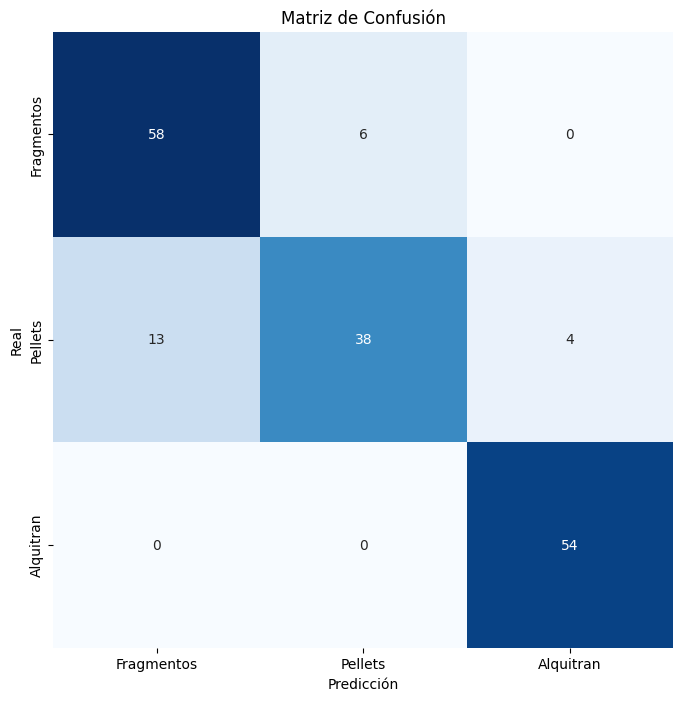

In [156]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Valores reales (fragmentos, pellets, alquitrán)
y_real = np.array([0] * 64 + [1] * 55 + [2] * 54)  # 0 = Fragmentos, 1 = Pellets, 2 = Alquitran

# Valores predichos basados en los resultados que diste
y_pred = np.array(
    [0] * 57 + [1] * 6  + [2] * 0 +  # Imagen de fragmentos
    [0] * 14 + [1] * 37 + [2] * 4 +  # Imagen de pellets
    [0] * 0  + [1] * 1  + [2] * 54   # Imagen de alquitran
)

# Verificar tamaño de los arrays
print("Tamaño de y_real:", len(y_real))  # Debe ser 189
print("Tamaño de y_pred:", len(y_pred))  # Debe ser 189

# Calcular métricas
accuracy = accuracy_score(y_real, y_pred)
precision = precision_score(y_real, y_pred, average='weighted')
recall = recall_score(y_real, y_pred, average='weighted')
f1score = f1_score(y_real, y_pred, average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")

# Calcular matriz de confusión
matriz_confusion = confusion_matrix(y_real, y_pred)

# Mostrar matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=['Fragmentos', 'Pellets', 'Alquitran'], yticklabels=['Fragmentos', 'Pellets', 'Alquitran'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()
